In [ ]:
# !apt-get install -y fonts-nanum
# !rm -rf ~/.cache/matplotlib
# !fc-cache -fv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [ ]:
# Download caption annotation files
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                            cache_subdir=os.path.abspath('.'),
#                                            origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                            extract=True)
#   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
#   os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)


else:
  PATH = os.path.abspath('.') + image_folder

image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

6645022720/6645013297 [==============================] - 124s 0us/step


In [ ]:
# 드라이브에 폴더생성
os.mkdir("/content/Multi")

In [ ]:
!unzip -uq "/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/MultiModule.zip" -d "/content/Multi/"

In [ ]:
len(os.listdir("/content/Multi"))

24010

In [ ]:
# 코랩에 직접적으로 다운하여 작업시 경로변수 설정
path_dir1 = '/content/train2014'
path_dir2 = '/content/val2014'
path_dir3 = '/content/Multi/'

# 드라이브 마운트하여 작업시 경로변수 설정
# path_dir1 = '/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/train2014'
# path_dir2 = '/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/val2014'

file_dir1 = os.listdir(path_dir1)
file_dir2 = os.listdir(path_dir2)
len(file_dir1), len(file_dir2) # train image : 82783장 / val image : 40504장

(82783, 40504)

In [ ]:
# 코랩에 직접적으로 다운하여 작업시 경로변수 설정
PATH = '/content/'

In [ ]:
# annotation_file = '/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoints(Ko)/MSCOCO_train_val_Korean.json'
# with open(annotation_file, 'r') as f:
#     annotations = json.load(f)
# len(annotations)

In [ ]:
import pandas as pd
df_MS = pd.read_csv('/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/MS_COCO_데이터정리(완료).csv')
df_MS['사진경로'] = PATH + df_MS['사진경로']
print(len(df_MS))
df_MS.head()

616767


,사진경로,캡셔닝_데이터
0,/content/val2014/COCO_val2014_000000391895.jpg,빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장도로를 달려 있다
1,/content/val2014/COCO_val2014_000000391895.jpg,시골의 비포장도로에서 오토바이를 타는 남자
2,/content/val2014/COCO_val2014_000000391895.jpg,오토바이 뒤에 탄 남자
3,/content/val2014/COCO_val2014_000000391895.jpg,오토바이 위에 젊은이가 탄 비포장도로는 다리가 있는 초록빛 지역의 전경과 구름 낀 ...
4,/content/val2014/COCO_val2014_000000391895.jpg,빨간 셔츠와 빨간 모자를 쓴 남자가 언덕 쪽 오토바이 위에 있다


In [ ]:
df_Multi = pd.read_csv('/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/멀티모달_데이터정리(완료).csv')
df_Multi['사진경로'] = path_dir3 + df_Multi['사진이름']
print(len(df_Multi))
df_Multi.head()

119825


,사진경로,사진이름,캡셔닝_데이터(종합),캡셔닝_데이터,캡셔닝_데이터(수정)
0,/content/Multi/KETI_SHOT_0000145756_KM_0000000...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자들이 있다,start 남자들이 있다 end
1,/content/Multi/KETI_SHOT_0000145756_KM_0000000...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자들은 서로 쳐다보고 있다,start 남자들은 서로 쳐다보고 있다 end
2,/content/Multi/KETI_SHOT_0000145756_KM_0000000...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 검정 머리이다,start 남자는 검정 머리이다 end
3,/content/Multi/KETI_SHOT_0000145756_KM_0000000...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 흰 셔츠를 입고 있다,start 남자는 흰 셔츠를 입고 있다 end
4,/content/Multi/KETI_SHOT_0000145756_KM_0000000...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 옆을 보고 있다,start 남자는 옆을 보고 있다 end


In [ ]:
# 사진 리사이징시 오류가 생기는 사진 파일 제외
df_Multi = df_Multi[df_Multi['사진이름'] != 'KETI_SHOT_0000142253_KM_0000014468.jpg']
df_Multi = df_Multi[df_Multi['사진이름'] != 'KETI_SHOT_0000123067_KM_0000000834.jpg']
df_Multi.reset_index(drop = True, inplace = True)

In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-uneb1_yv
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-uneb1_yv
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=485c533aaf55fa1015e23b5520eda257e27b7bffcf29a1cb6d3506c48e062345
  Stored in directory: /tmp/pip-ephem-wheel-cache-ifrskglo/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [ ]:
from tqdm.notebook import tqdm
from hanspell import spell_checker
import re

image_path_to_caption = collections.defaultdict(list)

# json 파일에서 추출 시 사용 코드(전처리가 안되어 있는 데이터이므로 사용하지 않을 것을 추천함)
# for val in annotations:
#   for i in range(len(val['caption_ko'])):
#     caption = f"start {val['caption_ko'][i]} end"
#     image_path = PATH + val['file_path']
#     image_path_to_caption[image_path].append(caption)

for index, val in enumerate(df_Multi['캡셔닝_데이터']):
    caption = f"start {val} end"
    image_path = df_Multi['사진경로'][index]
    image_path_to_caption[image_path].append(caption)

for index, val in enumerate(df_MS['캡셔닝_데이터']):
    caption = f"start {val} end"
    image_path = df_MS['사진경로'][index]
    image_path_to_caption[image_path].append(caption)

In [ ]:
# 딕셔너리 형태로 사진이름과 패딩한 캡션 값 저장
print(len(image_path_to_caption))
image_path_to_caption['/content/val2014/COCO_val2014_000000391895.jpg']
image_path_to_caption[df_Multi['사진경로'][0]]
# image_path_to_caption.keys()

147261


['start 남자들이 있다 end',
 'start 남자들은 서로 쳐다보고 있다 end',
 'start 남자는 검정 머리이다 end',
 'start 남자는 흰 셔츠를 입고 있다 end',
 'start 남자는 옆을 보고 있다 end']

In [ ]:
image_paths = list(image_path_to_caption.keys())
# random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths
print(len(train_image_paths), train_image_paths[:6], sep = ' ')

147261 ['/content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg', '/content/Multi/KETI_SHOT_0000145755_KM_0000000401.jpg', '/content/Multi/KETI_SHOT_0000145754_KM_0000000367.jpg', '/content/Multi/KETI_SHOT_0000145753_KM_0000000328.jpg', '/content/Multi/KETI_SHOT_0000145752_KM_0000000265.jpg', '/content/Multi/KETI_SHOT_0000145751_KM_0000000213.jpg']


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
train_captions[:6]

['start 남자들이 있다 end',
 'start 남자들은 서로 쳐다보고 있다 end',
 'start 남자는 검정 머리이다 end',
 'start 남자는 흰 셔츠를 입고 있다 end',
 'start 남자는 옆을 보고 있다 end',
 'start 과일이 있다 end']

In [ ]:
len(img_name_vector), img_name_vector[:6] # 한개의 사진에 달려있는 캡션이 5개 -> 5번째 이미지 벡터의 값이 앞의 내용과 달라짐

(736582,
 ['/content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg',
  '/content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg',
  '/content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg',
  '/content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg',
  '/content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg',
  '/content/Multi/KETI_SHOT_0000145755_KM_0000000401.jpg'])

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) 
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
# 새로 추가한 파일 중 resize가 안되는 사진 파일 확인(확인 후 제거 조치완료)
# for path in tqdm(df_Multi['사진경로']): 
#   try:
#     load_image(path)
#   except:
#     print(path)  

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
!pip install tqdm

736582
/content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg
start 남자들이 있다 end
start 남자들은 서로 쳐다보고 있다 end
start 남자는 검정 머리이다 end
start 남자는 흰 셔츠를 입고 있다 end
start 남자는 옆을 보고 있다 end


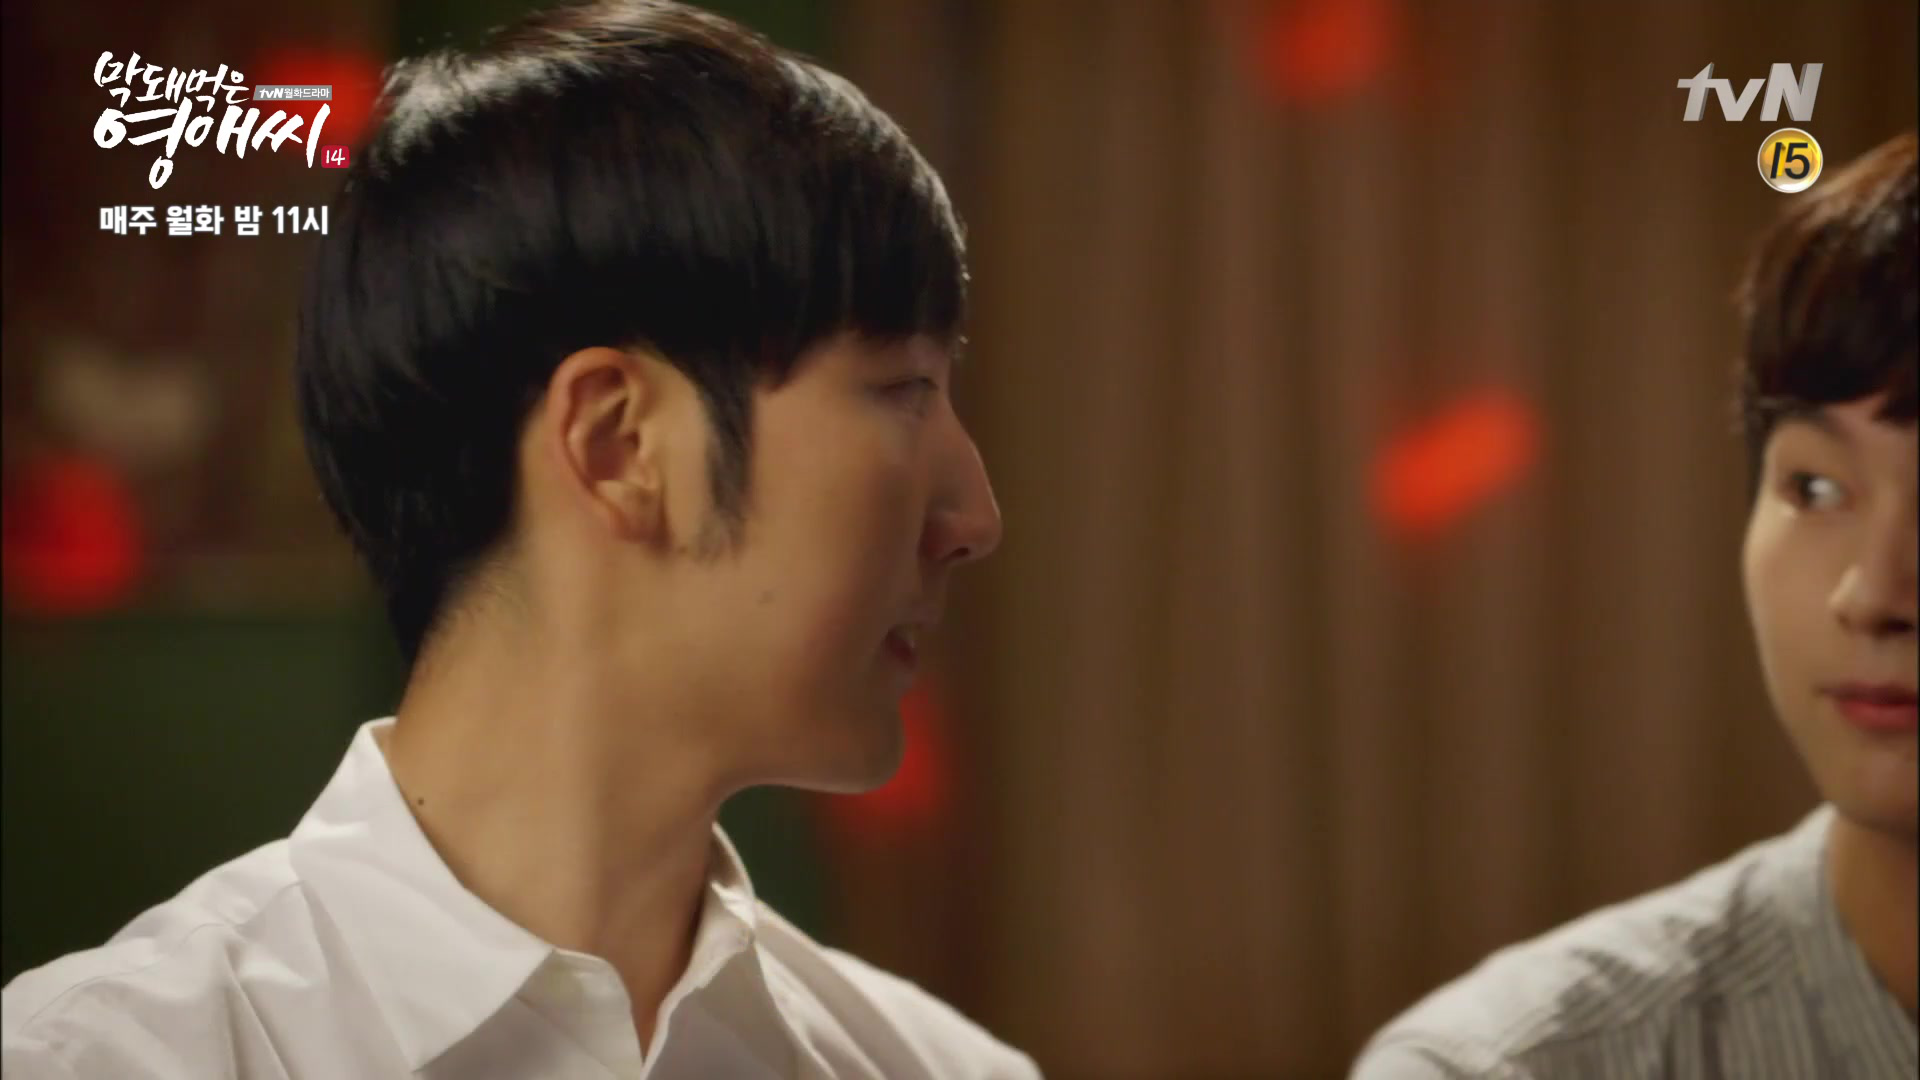

In [ ]:
print(len(img_name_vector), img_name_vector[0], sep = '\n')
for i in train_captions[0:img_name_vector.count(train_image_paths[0])]:
  print(i)
Image.open(img_name_vector[0])

In [ ]:
from tqdm.notebook import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                        (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

  0%|          | 0/9204 [00:00<?, ?it/s]

In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
!pip3 install JPype1
!pip3 install konlpy

     |████████████████████████████████| 448 kB 5.0 MB/s 
     |████████████████████████████████| 19.4 MB 267 kB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# 토크나이저 파일이 저장되어 있지 않으면 해당 코드들을 돌려서 토크나이저 진행
# konlpy의 Okt 사용 
# from tqdm.notebook import tqdm
# from konlpy.tag import Okt

# tokenizer = Okt()
# token_list = []
# for caption in tqdm(train_captions):
#     token_list.append(tokenizer.morphs(caption))

# token_list_ch = []
# for tokens in tqdm(token_list):
#     for token in tokens:
#         if token not in token_list_ch:
#             token_list_ch.append(token)

In [ ]:
# 토크나이저 파일이 저장되어 있지 않으면 해당 코드들을 돌려서 토크나이저 진행
# token_dict = dict()
# token_dict[0] = 'pad'
# token_dict[1] = 'unk'
# for index, value in enumerate(token_list_ch):
#     token_dict[index+2] = value
# index_to_word = token_dict.copy()
# word_to_index = dict()
# for key, value in index_to_word.items():
#     word_to_index[value] = key
# len(word_to_index) ,len(index_to_word)

In [ ]:
# 토크나이저 파일이 저장되어 있지 않으면 해당 코드들을 돌려서 토크나이저 진행
# 토큰나이저 속성결과 값 드라이브에 저장(체크포인트 활용하여 작업시 필요수치들)
# df_Tk = pd.DataFrame(word_to_index.items())
# df_Tk.columns = ['word', 'index']
# df_Tk.to_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/tokenizer(word_to_index_Okt).csv', index = False)

In [ ]:
import pandas as pd
df_Tk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/tokenizer(word_to_index_Okt).csv')
df_Tk.head()

,word,index
0,pad,0
1,unk,1
2,start,2
3,안경,3
4,을,4


In [ ]:
from tqdm.notebook import tqdm
from konlpy.tag import Okt
tokenizer = Okt()
word_to_index = dict(zip(df_Tk['word'], df_Tk['index']))
index_to_word = dict(zip(df_Tk['index'], df_Tk['word']))
len(word_to_index) ,len(index_to_word)

(27541, 27541)

In [ ]:
preprocessed_sentences = []
for i in tqdm(range(len(train_captions))):
    result = tokenizer.morphs(train_captions[i])
    preprocessed_sentences.append(result)

  0%|          | 0/736582 [00:00<?, ?it/s]

In [ ]:
# Create the tokenized vectors
train_seqs = []
for sentence in tqdm(preprocessed_sentences):
    train_seq = []
    for word in sentence:
        try:
            train_seq.append(word_to_index[word])
        except KeyError:
            train_seq.append(word_to_index['unk'])
    train_seqs.append(train_seq)

  0%|          | 0/736582 [00:00<?, ?it/s]

In [ ]:
# Choose the top 5000 words from the vocabulary
# top_k = 76000
# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
#                                                   oov_token="<unk>",
#                                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
# tokenizer.fit_on_texts(train_captions)

In [ ]:
# tokenizer.word_index['<pad>'] = 0
# tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
# train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# tokenizer.index_word[2]

In [ ]:
train_seqs[0]

[2, 6, 85, 16, 13, 14]

In [ ]:
len(word_to_index), len(index_to_word) 

(27541, 27541)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector[0]

array([ 2,  6, 85, 16, 13, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

58

In [ ]:
img_name_vector[0], cap_vector[0]

('/content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg',
 array([ 2,  6, 85, 16, 13, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=int32))

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
# 훈련, 검증, 테스트 데이터를 8 : 1 : 1로 분할
img_keys = list(img_to_cap_vector.keys())
# random.shuffle(img_keys) # 추후 재학습을 위해 랜덤셔플은 제거

slice_index1 = int(len(img_keys)*0.8)
slice_index2 = int(len(img_keys)*0.9)
img_name_train_keys, img_name_val_keys, img_name_test_keys = img_keys[:slice_index1], img_keys[slice_index1:slice_index2], img_keys[slice_index2:]

In [ ]:
# 테스트 데이터로 사용할 사진 이름 추출 및 저장
import pandas as pd
df_ti = pd.DataFrame({'testImage_Name' : img_name_test_keys})
df_ti.to_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/testImage_Nam(TK_OKT).csv', index = False)
df_ti.head()

,testImage_Name
0,/content/train2014/COCO_train2014_000000457734...
1,/content/train2014/COCO_train2014_000000306060...
2,/content/train2014/COCO_train2014_000000283666...
3,/content/train2014/COCO_train2014_000000452985...
4,/content/train2014/COCO_train2014_000000318924...


In [ ]:
print(f'slice_index1 : {slice_index1}, slice_index2 : {slice_index2}')
print(f'훈련 데이터 첫 데이터 : {img_name_train_keys[0]}')
print(f'검증 데이터 첫 데이터 : {img_name_val_keys[0]}')
print(f'테스트 데이터 첫 데이터 : {img_name_test_keys[0]}')

slice_index1 : 117808, slice_index2 : 132534
훈련 데이터 첫 데이터 : /content/Multi/KETI_SHOT_0000145756_KM_0000000448.jpg
검증 데이터 첫 데이터 : /content/train2014/COCO_train2014_000000254060.jpg
테스트 데이터 첫 데이터 : /content/train2014/COCO_train2014_000000457734.jpg


In [ ]:
print(f'총 데이터 수 : {len(img_keys)}')
print(f'훈련 데이터 수 : {len(img_name_train_keys)}')
print(f'검증 데이터 수 : {len(img_name_val_keys)}')
print(f'테스트 데이터 수 : {len(img_name_test_keys)}')
len(img_name_train_keys) + len(img_name_val_keys) + len(img_name_test_keys)

총 데이터 수 : 147261
훈련 데이터 수 : 117808
검증 데이터 수 : 14726
테스트 데이터 수 : 14727


147261

In [ ]:
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

img_name_test = []
cap_test = []
for imgv in img_name_test_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_test.extend([imgv] * capv_len)
  cap_test.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val), len(img_name_test), len(cap_test)

(589241, 589241, 73666, 73666, 73675, 73675)

In [ ]:
len(img_name_train) + len(img_name_val) + len(img_name_test)

736582

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(index_to_word) 
num_steps = len(img_name_train) // BATCH_SIZE
num_steps_val = len(img_name_val) // BATCH_SIZE
num_steps_test = len(img_name_test) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
num_steps, num_steps_val, num_steps_test

(9206, 1151, 1151)

In [ ]:
import json # 체크포인트를 로드하여 작업시 필요한 수치들 저장
values_ne = [dict({'embedding_dim' : 256, 'units' : 512, 'vocab_size' : len(index_to_word) , 'features_shape' : 2048, 'attention_features_shape' : 64})]
path = '/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/values(necessary).json'
with open(path, 'w') as outfile:
    json.dump(values_ne, outfile)

In [ ]:
with open(path, 'r') as f:
    json_data = json.load(f)
json_data

[{'attention_features_shape': 64,
  'embedding_dim': 256,
  'features_shape': 2048,
  'units': 512,
  'vocab_size': 27541}]

In [ ]:
vocab_size

27541

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
print(train_captions[1])
len(cap_train), cap_train[1] # img_name_train은 이미지 이름

start 남자들은 서로 쳐다보고 있다 end


(589241,
 array([   2,    6,   85,  173,  840, 2542,   13,   14,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0], dtype=int32))

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
              map_func, [item1, item2], [tf.float32, tf.int32]),
              num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_name_test, cap_test))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
              map_func, [item1, item2], [tf.float32, tf.int32]),
              num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val), len(img_name_test), len(cap_test)

(589241, 589241, 73666, 73666, 73675, 73675)

In [ ]:
len(dataset), len(val_dataset), len(test_dataset)

(9207, 1152, 1152)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
embedding_dim, units, vocab_size

(256, 512, 27541)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/train(val_image)"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50) # max_to_keep=3 : 최신체크포인트 중 몇개까지 저장할 건지 지정하는 옵션

In [ ]:
print(ckpt_manager.latest_checkpoint)

/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/train(val_image)/ckpt-17


In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  dec_input = tf.expand_dims([word_to_index['start']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
@tf.function
def val_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0]) 
  # dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  dec_input = tf.expand_dims([word_to_index['start']] * target.shape[0], 1)
  features = encoder(img_tensor)
  for i in range(1, target.shape[1]):
      # passing the features through the decoder
      predictions, hidden, _ = decoder(dec_input, features, hidden)
      loss += loss_function(target[:, i], predictions)
      total_loss = (loss / int(target.shape[1]))
  return loss, total_loss

In [ ]:
EPOCHS = 25

# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
loss_plot_val = []
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0
    total_loss_val = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 1000 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    
    
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss_val, t_loss_val = val_step(img_tensor, target)
        total_loss_val += t_loss_val
        
        if batch % 500 == 0:
            average_batch_loss_val = batch_loss_val.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss(val) {average_batch_loss_val:.4f}')
    loss_plot_val.append(total_loss_val / num_steps_val)

    # if epoch % 5 == 0:
    ckpt_manager.save()

    print(f'Epoch {epoch+1} : Loss {total_loss/num_steps:.6f} / Loss(val) {total_loss_val / num_steps_val:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18 Batch 0 Loss 0.2601
Epoch 18 Batch 1000 Loss 0.1764
Epoch 18 Batch 2000 Loss 0.4169
Epoch 18 Batch 3000 Loss 0.4466
Epoch 18 Batch 4000 Loss 0.4075
Epoch 18 Batch 5000 Loss 0.4308
Epoch 18 Batch 6000 Loss 0.4372
Epoch 18 Batch 7000 Loss 0.3776
Epoch 18 Batch 8000 Loss 0.4184
Epoch 18 Batch 9000 Loss 0.4218
Epoch 18 Batch 0 Loss(val) 1.5594
Epoch 18 Batch 500 Loss(val) 1.6564
Epoch 18 Batch 1000 Loss(val) 1.6314
Epoch 18 : Loss 0.375053 / Loss(val) 1.576649
Time taken for 1 epoch 5079.40 sec

Epoch 19 Batch 0 Loss 0.2718
Epoch 19 Batch 1000 Loss 0.1462
Epoch 19 Batch 2000 Loss 0.3492
Epoch 19 Batch 3000 Loss 0.4106
Epoch 19 Batch 4000 Loss 0.4691
Epoch 19 Batch 5000 Loss 0.4177
Epoch 19 Batch 6000 Loss 0.4261
Epoch 19 Batch 7000 Loss 0.4104
Epoch 19 Batch 8000 Loss 0.4042
Epoch 19 Batch 9000 Loss 0.4795
Epoch 19 Batch 0 Loss(val) 1.6009
Epoch 19 Batch 500 Loss(val) 1.6282
Epoch 19 Batch 1000 Loss(val) 1.6388
Epoch 19 : Loss 0.372932 / Loss(val) 1.581084
Time taken for 1 epoch 2

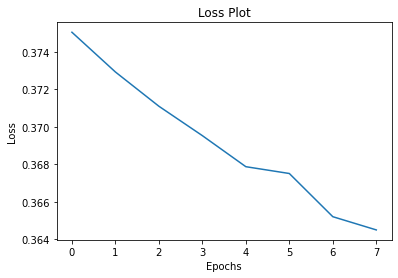

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

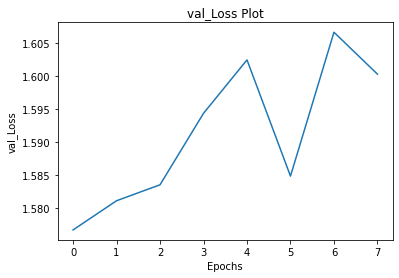

In [ ]:
plt.plot(loss_plot_val)
plt.xlabel('Epochs')
plt.ylabel('val_Loss')
plt.title('val_Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    dec_input = tf.expand_dims([word_to_index['start']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(index_to_word[predicted_id])

        # if tokenizer.index_word[predicted_id] == '<end>':
        #     return result, attention_plot
        if index_to_word[predicted_id] == 'end':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: start 트럭 을 타고 길 을 따라 운전 해 내려가는 플랫 베드 위 에 타고 있는 남자 end
Prediction Caption: 군인 은 가까운 흙 속 을 내려오고 있다 end


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44400 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44620 missing from current font.
  font.set_text(

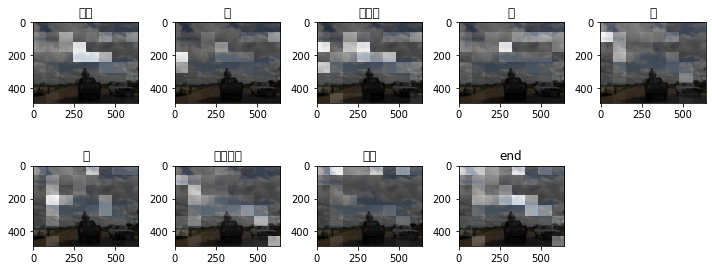

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i]
#                         for i in cap_val[rid] if i not in [0]])
real_caption = ' '.join([index_to_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
import os
path_dir = '/content/val2014/'
file_dir = os.listdir(path_dir)
path_dir + file_dir[0]

'/content/val2014/COCO_val2014_000000011081.jpg'

Prediction Caption: 고기 가 치즈 상추 를 곁들인 뛰놀았다 end


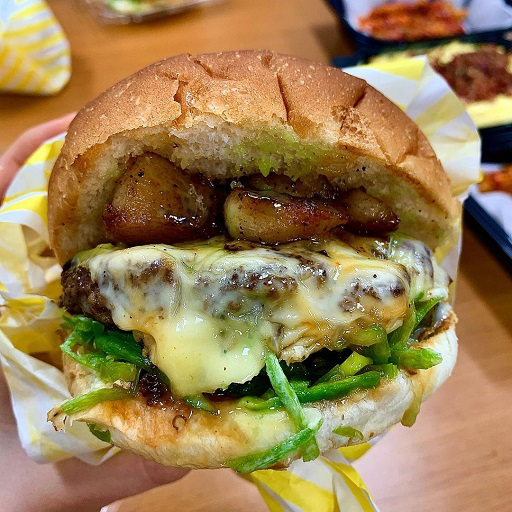

In [ ]:
import random 
i = random.randint(0, len(file_dir))
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-3:]
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
# image_path = '/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/test_image/1.jpg'
# image_path = path_dir + file_dir[i]
image_path = '/content/15.jpg'

result, attention_plot = evaluate(image_path)
# result, attention_plot = evaluate(img)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)